## Fine Tuning Model

In [2]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# install huggingface libraries
# !pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [4]:
# imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [6]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [7]:
# checking if data is stored correctly in Colab Notebooks/data
!ls /drive/My\ Drive/Colab\ Notebooks/data/*.py

'/drive/My Drive/Colab Notebooks/data/utils_squad_evaluate.py'
'/drive/My Drive/Colab Notebooks/data/utils_squad.py'


In [8]:
import sys
sys.path.append('/drive/My Drive/Colab Notebooks/data')

In [9]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [10]:
# cuda is an NVIDIA toolkit that provides a dev environment for GPU-accelerated apps
# checking if cuda is available to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# getting a could not find answer error, this stems from not being able to find the answer
# exactly how it is in the context because either added tokens or lowercase uppercase
# WARNING: do not edit the answers when labelling
input_file = '/drive/My Drive/Colab Notebooks/data/data_struct_ext-v1.1.json'
# reading in the input .json file
# the version_2_with_negative: if true, the SQuAD examples contain some that do not have an answer
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=False)

Could not find answer: 'Class Hierarchies (assuming single inheritance). The subclass is the child and the superclasses isthe parent. The python class  object  is the root.File folders or directories on a computer can be nested inside other directories. The parent-childrelationship encode containment.The' vs. 'Class Hierarchies (assuming single inheritance). The subclass is the child and the superclasses isthe parent. The python class object is the root.File folders or directories on a computer can be nested inside other directories. The parent-childrelationship encode containment'
Could not find answer: 'Has all expected methods and features• add(int index, Object element) • add(Object o)• addAll(Collection c)• addAll(int index, Collection c) • addFirst(Object o) • addLast(Object o) • contains(Object o) • get(int index) • getFirst() • getLast() • indexOf(Object o) • lastIndexOf(Object o) • remove(int index) • remove(Object o) • removeFirst() • removeLast() • set(int index, Object elem

In [12]:
examples[:2]

[qas_id: a5570602-91e4-4fca-9d1a-e1d24877a615, question_text: what are some data structures used to store lists?, doc_tokens: [LISTS=====Let’s consider two different data structures for storing a list of things:an array and a linked list.], start_position: 4, end_position: 16,
 qas_id: 81476860-90cf-4481-bfa5-1d8d77d1ec47, question_text: what is the advantage of using an array to store a list?, doc_tokens: [An array is a pretty obvious way to store a list, with a big advantage: itenables very fast access of each item. However, it has two disadvantages.], end_position: 21]

In [13]:
# creating a pandas df from the examples loaded above
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,a5570602-91e4-4fca-9d1a-e1d24877a615,what are some data structures used to store li...,"[LISTS=====Let’s, consider, two, different, da...",data structures for storing a list of things:a...,4,16,False
1,81476860-90cf-4481-bfa5-1d8d77d1ec47,what is the advantage of using an array to sto...,"[An, array, is, a, pretty, obvious, way, to, s...",An array is a pretty obvious way to store a li...,0,21,False
2,ec176d1d-1c33-46d3-a58f-9d19d372ad5a,what is the disadvantage of storing a list usi...,"[First,, if, we, want, to, insert, an, item, a...","First, if we want to insert an item at the beg...",0,37,False
3,c7e42265-ce26-4b63-b768-09eb950d31c8,how long does inserting an item in an array take?,"[First,, if, we, want, to, insert, an, item, a...",This takes timeproportional to the length of t...,29,37,False
4,537f441e-315c-4a42-887b-453fc86ef005,what is the disadvantage of using an array to ...,"[Second,, an, array, has, a, fixed, length, th...",an array has a fixed length that can’t be chan...,1,43,False


In [14]:
# taking a sample from the train_data above
# display the first row -> head(1)
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
448,49a74458-2dee-417b-bbc1-a939af566328,what is an adjacency list?,"[Representing, a, Graph, Using, an, Adjacency,...",Adjacency list = a list (either an array or li...,7,31,False
449,adf087b3-492f-4a25-9ba8-6fd2d4a313a7,when is an adjacency list representation of a ...,"[Representing, a, Graph, Using, an, Adjacency,...",This representation is good if a graph is spar...,50,66,False
450,aaff94db-24c8-4113-b678-dc57a32f1ab7,how are missing edges represented in adjacency...,"[Representing, a, Graph, Using, an, Adjacency,...","No memory is allocated for non-existent edges,...",33,49,False


In [15]:
import random
# pick a random context and print out the questions and answers associated with it in a pretty format
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(2*separator_length//4-len(question)+9), (answer if answer else 'No answer found'))

In [16]:
print_squad_sample(train_data)

CONTEXT: 
Breadth-first search (BFS) starts by visiting an arbitrary vertex, then visitsall vertices whose distance
from the starting vertex is one, then all verticeswhose distance from the starting vertex
is two, and so on. If your graph is anundirected tree, BFS performs a
level-order tree traversal.
QUESTION:                                                                                            ANSWER:
describe BFS briefly                                                   Breadth-first search (BFS) starts by visiting an arbitrary vertex, then visitsall vertices whose distance from the starting vertex is one, then all verticeswhose distance from the starting vertex is two, and so on.
what kind of traversal does BFS perform for an undirected tree?        If your graph is anundirected tree, BFS performs a level-order tree traversal.


In [17]:
# adding cols for paragraph_len and question_len in the train data
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
# viewing first 5 entries
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
471,b95e33ac-971b-4c0c-a805-2814a98c11a1,how can we find the shortest path in an unweig...,"[The, Shortest-Path, Problem•, It’s, often, us...","For an unweighted graph, we can simply do the ...",32,75,False,124,57
375,9d018b5c-cb9b-4841-886a-24fe5c0c922d,what does Kruskal's algorithm do?,"[Kruskal’s, algorithm, computes, the, mimimum,...",Kruskal’s algorithm computes the mimimum spann...,0,8,False,73,33
117,e046f5ea-80ae-4dc5-830c-992cecdebbc4,what is a binary tree?,"[Binary, Trees, , A, binary, tree, is, either...",A binary tree is a nonlinear data structure,25,32,False,71,22
80,644e2d95-0742-4eae-9cab-bddbe4fc619d,what does the prev pointer of the first node r...,"[Doubly-Linked, Lists, , Each, data, entry, i...",the first node in the list contains a prev ref...,84,95,False,109,54
400,41604581-b75f-44ef-a9b0-cf38e2a1c249,when is a graph strongly connected?,"[A, graph, is, _strongly_connected_, if, there...",A graph is _strongly_connected_ if there is a ...,0,22,False,28,35


(array([101., 210., 108., 107.,  50.,  35.,  13.,   2.,   1.,   2.]),
 array([ 15. ,  24.6,  34.2,  43.8,  53.4,  63. ,  72.6,  82.2,  91.8,
        101.4, 111. ]),
 <a list of 10 Patch objects>)

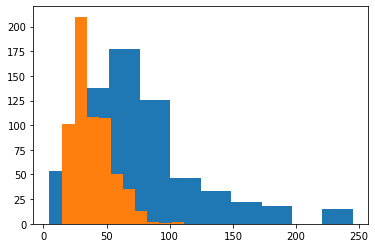

In [18]:
# looking at the distribution of token lengths
plt.hist(train_data['paragraph_len'])

plt.hist(train_data['question_len'])

# we find that most of the data lies below 150 so we set the context len to 150
# ignore very long outliers like 450

# question lengths lie below 100 so we set max to 100

In [19]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 100.0%


In [20]:
# download a pretrained tokenizer
# bert uncased doesn't take into account the case of the letters
# base tokenizer is the complete one - not light version
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [21]:
# if the document is longer than the max_seq_length, we use a sliding window of size doc_stride to traverse
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [22]:
# loads a data file into a list of input batches
features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
# save to the features file
torch.save(features, 'cached_features_file')

In [23]:
# we want experiment to be reproducible
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [24]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [25]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [31]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/Colab Notebooks/data/checkpoint*-[0-9]*'))

In [27]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [32]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/Colab Notebooks/data/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [33]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0187,  0.0181,  0.0130,  ..., -0.0040,  0.0066,  0.0127],
        [ 0.0109,  0.0022, -0.0203,  ...,  0.0200, -0.0169, -0.0044]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [34]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [35]:
num_train_epochs = 20

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 10 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/Colab Notebooks/data/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

Iteration:   0%|          | 0/41 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 661
  Num Epochs = 20
  Batch size = 16
  Total optimization steps = 2



Iteration:  24%|██▍       | 10/41 [00:08<00:28,  1.08it/s]

Train loss: 4.443995785713196



Iteration:  27%|██▋       | 11/41 [00:11<00:43,  1.46s/it]

Saving model checkpoint to /drive/My Drive/Colab Notebooks/data/checkpoint-10



Iteration:  49%|████▉     | 20/41 [00:19<00:20,  1.01it/s]

Train loss: 3.853974795341492



Iteration:  51%|█████     | 21/41 [00:22<00:31,  1.57s/it]

Saving model checkpoint to /drive/My Drive/Colab Notebooks/data/checkpoint-20



Iteration:  73%|███████▎  | 30/41 [00:31<00:10,  1.05it/s]

Train loss: 3.454720616340637



Iteration:  76%|███████▌  | 31/41 [00:34<00:15,  1.53s/it]

Saving model checkpoint to /drive/My Drive/Colab Notebooks/data/checkpoint-30



Iteration:  98%|█████████▊| 40/41 [00:42<00:00,  1.09it/s]

Train loss: 3.233428329229355



Iteration: 100%|██████████| 41/41 [00:00<00:00, 1404.17it/s]

Saving model checkpoint to /drive/My Drive/Colab Notebooks/data/checkpoint-40



Epoch: 100%|██████████| 20/20 [00:46<00:00,  2.33s/it]


In [36]:
output_dir = '/drive/My Drive/Colab Notebooks/data/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [37]:
train_loss_set_ckpt = torch.load('/drive/My Drive/Colab Notebooks/data/checkpoint-40/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

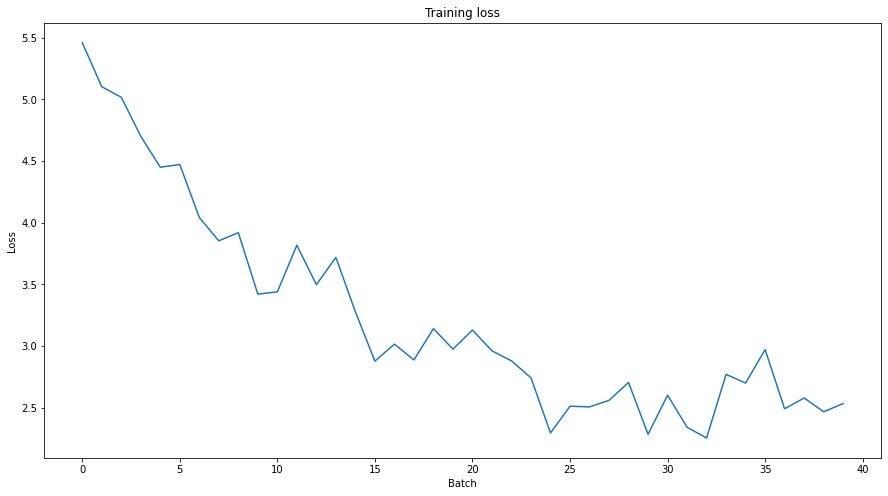

In [38]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Converting app to .joblib

In [ ]:
!pip install cdqa
# #!git clone https://github.com/cdqa-suite/cdQA.git
# %cd cdQA/
# !pip install -e .

In [ ]:
!pip install scikit-learn==0.22
!pip install joblib==0.14

In [39]:
# This is for converting the model to a .joblib so we can use streamlit to make
# it into a web app (https://github.com/cdqa-suite/cdQA/issues/324)

# Let's call your pytorch model Bert for QA custom_qa_model
from cdqa.reader import BertQA

reader = BertQA()
reader.model = model

# You need to send the model to CPU in order to save in the joblib format
reader.model.to('cpu')
reader.device = torch.device('cpu')

# Save it in the joblib format
import joblib
import os

joblib.dump(reader, os.path.join("/drive/My Drive/Colab Notebooks/data/", 'extended_CS231_bert.joblib'))

['/drive/My Drive/Colab Notebooks/data/extended_CS231_bert.joblib']

## App Deployment

In [ ]:
# using streamlit to create the app
!pip install streamlit

In [ ]:
# creates a secure tunnel through which the 
!pip install pyngrok==4.1.1

In [ ]:
%%writefile bertdeploy.py
import joblib
import requests
import streamlit as st

def main():

  st.set_option('deprecation.showfileUploaderEncoding', False)
  st.title("Question Answering Webapp")
  st.text("What would you like to know about Data Structures today?")

  @st.cache(allow_output_mutation=True)

  def load_model():
    model = joblib.load('/content/drive/My Drive/Colab Notebooks/data/custom_qa_bert.joblib')
    return model

  with st.spinner("Loading model into memory ..."):
    model = load_model()

  text = st.text_input("Enter your questions here...")

  if text:
    st.write("Response: ")

    with st.spinner("Searching for answers ..."):
      prediction = model.predict(text)
      st.write("answer: {}".format(prediction[0]))
      st.write("title: {}".format(prediction[1]))
      st.write("paragraph: {}".format(prediction[2]))
    st.write("")

if __name__ == "__main__":
  main()

In [ ]:
!ngrok authtoken 1nnk5fe5IOm0N1ZbjgKZktXQlgZ_3WBfRozA6g8VadzTz9vwU

In [ ]:
from pyngrok import ngrok

In [ ]:
# !nohub streamlit run bertdeploy.py
!streamlit run bertdeploy.py&>/dev/null&

In [ ]:
!pgrep streamlit

In [ ]:
publ_url = ngrok.connect(port='8501')

In [ ]:
publ_url

In [ ]:
ngrok.kill()